## Loading Dependencies

In [2]:
%pip install pandas
%pip install matplotlib
%pip install plotly
%pip install scikit-learn
%pip install numpy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
                                              0.0/15.5 MB ? eta -:--:--
     -                                        0.4/15.5 MB 8.3 MB/s eta 0:00:02
     -                                        0.7/15.5 MB 8.9 MB/s eta 0:00:02
     -                                        0.7/15.5 MB 8.9 MB/s eta 0:00:02
     --                                       1.1/15.5 MB 6.1 MB/s eta 0:00:03
     ---                                      1.5/15.5 MB 7.6 MB/s eta 0:00:02
     -----                                    2.0/15.5 MB 8.0 MB/s eta 0:00:02
     ------                                   2.6/15.5 MB 8.3 MB/s eta 0:00:02
     -------                                  3.1/15.5 MB 8.8 MB/s eta 0:00:02
     ---------                                3.5/15.5 MB 9.0 MB/s eta 0:00:02
     ----------                               4.0/15.5 MB 9.1 MB/s eta 0:00:02
     -

## Importing Libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import plotly.graph_objects as go

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Stage: Preprocessing
##### Loading in the Badminton Serving Data. 
- Blank rows are used to separarate observations. 
- Non-sparse data are filtered out
- Data is grouped into observations labelled under data column "OBSERVATION DATA"
- There are a total of 365 (index 0 - 364) observation groups here
- Data is indicated as serving data with 1 under data column "SERVING"
#### Code is currently commented out as results has already been extracted

In [4]:
# # read csv data from badmintondata.csv
# serving_data = pd.read_csv('badmintondata.csv')

# observation_num = 0
# is_group = False

# # used to filter out blank rows while also labelling data based on their observation groups
# for index, row in serving_data.iterrows():
#     if row['HUMAN PLAYER POSITION (X) metres'] == 0:
#         if is_group:
#             observation_num += 1
#             is_group = False
#         serving_data.drop(index, inplace=True)
#     elif row['HUMAN PLAYER POSITION (X) metres'] == 4 and not is_group:
#         is_group = True
#         serving_data.at[index, 'OBSERVATION NUMBER'] = observation_num
#     elif row['HUMAN PLAYER POSITION (X) metres'] == 4 and is_group:
#         serving_data.at[index, 'OBSERVATION NUMBER'] = observation_num

# serving_data['OBSERVATION NUMBER'] = serving_data['OBSERVATION NUMBER'].astype(int)
# serving_data['SERVING SHOT'] = 1

# # output served data to csv
# rally_data.to_csv('cleaned_served_badminton.csv')

##### Loading in the Badminton Rallying Data. 
- Blank rows are used to separarate observations. 
- Non-sparse data are filtered out
- Data is grouped into observations labelled under data column "OBSERVATION DATA". 
- There are a total of 1212 (index 364 - 1576) observation groups here
- Data is indicated as serving data with 0 under data column "SERVING"
#### Code is currently commented out as results has already been extracted

In [5]:
# # returning shots after the serving shot
# rally_data = pd.read_csv('badmintondata2.csv')
# # sample_rally_data = rally_data.head(1000)
# is_group = False

# for index, row in rally_data.iterrows():
#     if row['HUMAN PLAYER POSITION (X) metres'] == 0:
#         if is_group:
#             observation_num += 1
#             is_group = False
#         rally_data.drop(index, inplace=True)
#     elif row['HUMAN PLAYER POSITION (X) metres'] == 4 and not is_group:
#         is_group = True
#         rally_data.at[index, 'OBSERVATION NUMBER'] = observation_num
#     elif row['HUMAN PLAYER POSITION (X) metres'] == 4 and is_group:
#         rally_data.at[index, 'OBSERVATION NUMBER'] = observation_num

# # ensure observation numbers are integers
# rally_data['OBSERVATION NUMBER'] = rally_data['OBSERVATION NUMBER'].astype(int)
# # indicates if observation is a service shot or not
# rally_data['SERVING SHOT'] = 0

# # output rally data to csv
# rally_data.to_csv('cleaned_rally_badminton.csv')

#### Combining preprocessing
- combine cleaned served and rallied dataframes
- label data if they are are out of bounds within the observations using data column "OUT OF BOUNDS". This includes
    - Data that exceeds the X axis (hit too far on both sides) X < 0 OR X > 13.4
    - Data that exceeds the Y axis (hit out of court on left or right side) Y < 0 OR Y > 5.18
    - Data that is out of bounds labelled as 1, no 0
#### Code is currently commented out as results has already been extracted

In [6]:
# # combining the serving and rally dataframes
# badminton_data = pd.concat([serving_data, rally_data], ignore_index=True)
# # labelling data if its out of bounds
# unique_observation_number = badminton_data['OBSERVATION NUMBER'].unique()
# for obs_number in unique_observation_number:
#     last_row = badminton_data[badminton_data['OBSERVATION NUMBER'] == obs_number].tail(1)
#     # Check the conditions for 'Shuttlecock Position in Air X' and 'Shuttlecock Position in Air Y'
#     if (last_row['SHUTTLECOCK POSITIION IN AIR(X ) metres'].values[0] < 0 or
#         last_row['SHUTTLECOCK POSITIION IN AIR(X ) metres'].values[0] > 13.4 or
#         last_row['SHUTTLECOCK POSITIION IN AIR(Y) metres'].values[0] < 0 or
#         last_row['SHUTTLECOCK POSITIION IN AIR(Y) metres'].values[0] > 5.18):
        
#         # Set 'OUT OF BOUNDS' column to 1 for the corresponding observation number
#         badminton_data.loc[badminton_data['OBSERVATION NUMBER'] == obs_number, 'OUT OF BOUNDS'] = 1
#     else:
#         badminton_data.loc[badminton_data['OBSERVATION NUMBER'] == obs_number, 'OUT OF BOUNDS'] = 0
    
# badminton_data.to_csv('cleaned_combined_data.csv')

#### Temporary Loading of Data to avoid excessive computation

In [23]:
cleaned_data = pd.read_csv('cleaned_badminton.csv')
# removal indexes
cleaned_data = cleaned_data.drop(columns=['Unnamed: 0'])

### Insertion of sequence numbers into the data

### Normalization of Data

In [24]:
# removal of labels and dependent features
X_Features = cleaned_data.drop(columns=['OBSERVATION NUMBER', 
                                               'SERVING SHOT', 
                                               'OUT OF BOUNDS', 
                                               'SHUTTLECOCK POSITIION IN AIR(X ) metres', 
                                               'SHUTTLECOCK POSITIION IN AIR(Y) metres', 
                                               'SHUTTLECOCK POSITIION IN AIR(Z) metres'])
# Standardize the data
scaler = StandardScaler()
X_features_norm = scaler.fit_transform(X_Features)

#### Significance of Independent Features with PCA

Feature 4: Significance = 0.2153570406161256
Feature 2: Significance = 0.21526042792827146
Feature 3: Significance = 0.2118031116223317
Feature 1: Significance = 0.21172552376663786
Feature 0: Significance = 0.14585389606663324


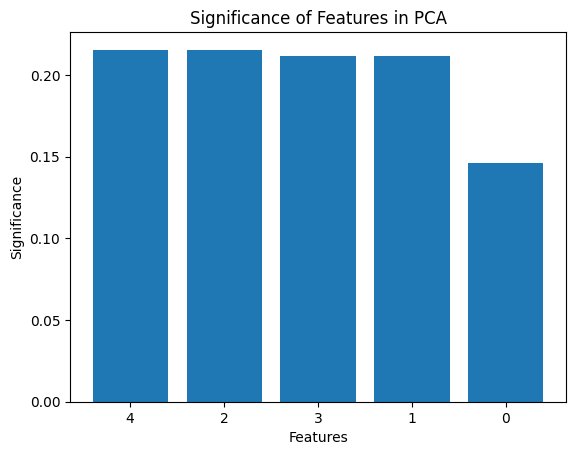

In [29]:
# instantiate PCA object, fit model
pca = PCA()
pca.fit(X_features_norm)

# loadings refer to the coefficients or weights that determine the contribution of each feature to the principal components
# Get the absolute loadings for each feature in each principal component
absolute_loadings = np.abs(pca.components_)
# Calculate the total sum of absolute loadings for each feature across all principal components
total_loadings = np.sum(absolute_loadings, axis=0)

# Calculate the relative contribution of each feature to the total loadings
relative_contribution = total_loadings / np.sum(total_loadings)

# Sort the features based on their relative contribution
sorted_features = np.argsort(relative_contribution)[::-1]

# Print the significance of each feature
for feature_idx in sorted_features:
    print(f"Feature {feature_idx}: Significance = {relative_contribution[feature_idx]}")

# Plot the significance of each feature
plt.bar(range(len(sorted_features)), relative_contribution[sorted_features])
plt.xlabel('Features')
plt.ylabel('Significance')
plt.title('Significance of Features in PCA')
plt.xticks(range(len(sorted_features)), sorted_features)
plt.show()

In [10]:
# # Assuming you have a DataFrame named 'sample_serving_data' with columns 'OBSERVATION NUMBER',
# # 'SHUTTLECOCK POSITIION IN AIR(X) metres', 'SHUTTLECOCK POSITIION IN AIR(Y) metres',
# # and 'SHUTTLECOCK POSITIION IN AIR(Z) metres'

# # Filter rows starting from row 2
# df_filtered = sample_serving_data.iloc[2:]

# # Get the maximum group_id value
# max_group_id = df_filtered['OBSERVATION NUMBER'].max()

# fig = go.Figure()

# for group_id in range(max_group_id + 1):
#     group_df = df_filtered[df_filtered['OBSERVATION NUMBER'] == group_id]
#     x = group_df['SHUTTLECOCK POSITIION IN AIR(X ) metres']
#     y = group_df['SHUTTLECOCK POSITIION IN AIR(Y) metres']
#     z = group_df['SHUTTLECOCK POSITIION IN AIR(Z) metres']
    
#     fig.add_trace(go.Scatter3d(
#         x=x, y=y, z=z,
#         mode='markers',
#         name=f'Group {group_id}'
#     ))

# fig.update_layout(
#     scene=dict(
#         xaxis=dict(title='X'),
#         yaxis=dict(title='Y'),
#         zaxis=dict(title='Z')
#     ),
#     title='Interactive 3D Plot'
# )
# fig.write_html("interactive_plot.html")

# # fig.show()

In [11]:
# sample_serving_data = serving_data.head(1000)
# # sample_serving_data.head()
# df_filtered = sample_serving_data.iloc[2:]
# max_group_id = df_filtered['OBSERVATION NUMBER'].max()
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# for group_id in range(max_group_id + 1):
#     group_df = df_filtered[df_filtered['OBSERVATION NUMBER'] == group_id]
#     x = group_df['SHUTTLECOCK POSITIION IN AIR(X ) metres']
#     y = group_df['SHUTTLECOCK POSITIION IN AIR(Y) metres']
#     z = group_df['SHUTTLECOCK POSITIION IN AIR(Z) metres']
    
#     ax.scatter(x, y, z)

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')

# plt.show()